In [1]:

# Add PATH
push!(LOAD_PATH, joinpath(@__DIR__, "..", "src"))

#using PyPlot
using Plots
using BenchmarkTools
using DifferentialEquations

using LSM.PhysCon
using LSM.WaterVaporMod
#using LSM.LeafPhotosynthesisMod
using LSM.LeafEnergyWaterBalanceMod

output_dir = joinpath(@__DIR__,"..","output")
mkpath(output_dir)

"/Users/gentine/Dropbox/Collaborations_Projects/Optimal_Stomata/LSM-SPAM/test/../output"

In [2]:

# function lorenz!(du,u,p,t)
#  du[1] = 10.0*(u[2]-u[1]);
#  du[2] = u[1]*(28.0-u[3]) - u[2];
#  du[3] = u[1]*u[2] - (8/3)*u[3];
# end
# u0 = [1.0;0.0;0.0];
# tspan = (0.0,100.0);
# prob = ODEProblem(lorenz!,u0,tspan);
# sol = solve(prob);

# plot(sol,vars=(1,2,3))

# Create a leaf structure
l = leaf_params{Float32}();
# Create a Flux structure
f = fluxes{Float32}();
# Create a meteo structure
met = meteo{Float32}();

#met = meteo();

# initialize some reasonable values
f.Je   = 100; f.gbc  = 100; f.gbv  = 100; f.ceair= 1500; f.eair = 1500; f.APAR = 500; # leaf should not have eair
l.Kn = 2.44; l.α=0.2; l.ε=0.98; l.LMA=40e-3; l.c_leaf=50/100*4184;l.ra=50;l.psi_l=-1e6;l.psi_l50 = -2e6;l.ck=3;


In [3]:

# A diurnal cycle for radiation and Tair
Deltat  = 60;
Samp    = 500; # W/m2 amplitude
Tmean   = 273.15+22;
DeltaT  = 3;
omega   = 2*π/(24*3600);
t       = range(0, stop=24*3600, step=Deltat); # diurnal cycle in seconds
#print(t)
phi_t   = omega*t-π*ones(size(t))/2;
Sdown_t = zeros(size(t));
Tair_t  = zeros(size(t));
zeros_t = zeros(size(t));
for i = 1:length(Sdown_t)
    Sdown_t[i] = Samp*max( sin(phi_t[i]),zeros_t[i] );#max(sin(phase[i]),zeros(size(t[i])));
    Tair_t[i]  = Tmean + DeltaT*sin(phi_t[i]-π/3);
end
#print(typeof(phase[1]));
#print(typeof(Sdown_t[1]));
#print(Sdown_t);
#clf();
#fig = figure("Diurnal cycle", figsize=(10,5));
# plot(t/3600,Sdown_t)
#plot!(t/3600,10*(Tair_t-273.15*ones(size(Tair_t))))
#    title = "Shortwave Incoming radiation (W/m^2)");#,
#    xlabel = "Hours",
#    ylabel = "S_{down} (W/m^2)")
#plot(t/3600,Tair_t-273.15*ones(size(Tair_t)),
#    title = "Temperature (C)",
#    xlabel = "Hours",
#    ylabel = "Temperature (C)")


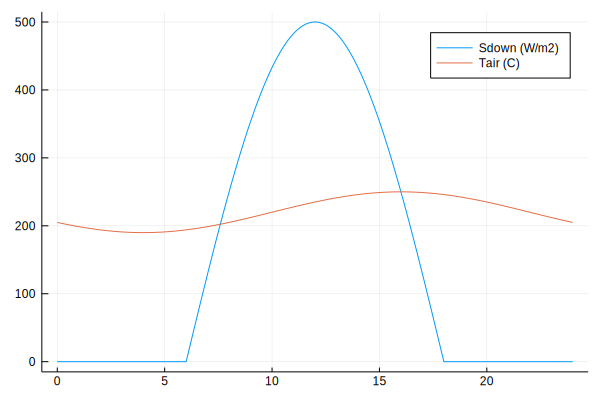

In [4]:
plot(t/3600,Sdown_t,label="Sdown (W/m2)")
plot!(t/3600,10*(Tair_t-273.15*ones(size(Tair_t))),label="Tair (C)")

In [5]:
psi_s      = -0.3e6 ; # soil water potential (Pa)
U          =  1.0;
RH         =  65/100;
eps_air    =  0.75;
tspan      =  (0.0,Deltat);
N          =  length(Sdown_t);
mutable struct parameters_ode
    l::leaf_params;
    met::meteo;
    f::fluxes;
    psi_s;
end
    

In [6]:
# small time stepping
dt = 0.01*60; # in s
T_t    = zeros(size(Sdown_t));
psil_t = zeros(size(Sdown_t));
Rn_t   = zeros(size(Sdown_t));
H_t    = zeros(size(Sdown_t));
LE_t   = zeros(size(Sdown_t));
dummy  = zeros(5,1);
met.zscreen  = 20.0 + 2.0;

function f_ode!(du,u,p,t,dummy) # p are parameters
    dummy .= LeafEnergyWaterBalance(u[1], u[2], p.met, p.l, p.f, p.psi_s);
    du    .= dummy[1:2];
    #println("du_inside = $(du), u_inside = $(u)")
end

let
    for i=1:N
        met.S_down = Sdown_t[i];
        met.L_down = eps_air*physcon.σ*(Tair_t[i])^4;
        met.T_air  = Tair_t[i];
        met.e_air  = RH*SatVap(Tair_t[i])[1];
        met.PAR    = 45/100*physcon.Wtoμmole_s*Sdown_t[i];
        f.APAR     = met.PAR;
        met.U      = U;
        met.Ca     = 400.0; #ppm
        f.APAR     = met.PAR;
        for j=1:trunc(Deltat/dt)
            u    = [l.T;l.psi_l];
            p    = parameters_ode(l,met,f,psi_s);
            #(p.met, p.l,  p.psi_s, p.U)    = [l;met;psi_s;U];
            #prob = ODEProblem(f_ode!,u0,tspan,p);
            du   = zeros(size(u));
            f_ode!(du,u,p,t,dummy);
            #println("du_outside = $(du), u_outside = $(u)")
            (l.T,l.psi_l) = du*dt+u;
            T_t[i]  = l.T; psil_t[i]=l.psi_l;
            Rn_t[i] = dummy[3]; H_t[i] = dummy[4]; LE_t[i] = dummy[5];
        end
    end

#     l.T        = Tair_t[1]; # initialize temperature of the leaf
#     l.psi_l    = psi_s;

#     for i=1:N
#         met.S_down = Sdown_t[i];
#         met.L_down = eps_air*physcon.σ*(Tair_t[i])^4;
#         met.T_air  = Tair_t[i];
#         met.ea_air = RH*SatVap(Tair_t[i])[1];
#         u0   = [l.T;l.psi_l];
#         p    = parameters_ode(l,met,psi_s);
#         #(p.met, p.l,  p.psi_s, p.U)    = [l;met;psi_s;U];
#         prob = ODEProblem(f_ode!,u0,tspan,p);
#         sol  = solve(prob);
#         (l.T,l.psi_l) = sol[:,end];
#         T_t[i] = l.T; psil_t[i]=l.psi_l;
#         #print((l.T,l.psi_l) )
#         #dT_dt,dH2Ol_dt = LeafEnergyWaterBalance(met, l, psi_s);
#         #l.T        = l.T + Deltat*dT_dt;
#     end

   
end


ra=17.910538 (s/m), H=0.0 (W/m2)
Sdown= 0.0W/m2, Rn=-122.882965W/m2, SEB=-422.50348W/m2, H= 299.6087W /m2, LE= 0.011821513W /m2, dT_dt=-18176.537 (K/hr), rs=2.4417622e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=299.6087 (W/m2)
Sdown= 0.0W/m2, Rn=-105.3074W/m2, SEB=-203.2262W/m2, H= 97.91086W /m2, LE= 0.007935487W /m2, dT_dt=-8743.001 (K/hr), rs=2.4417622e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=97.91086 (W/m2)
Sdown= 0.0W/m2, Rn=-97.0441W/m2, SEB=-97.94438W/m2, H= 0.89401466W /m2, LE= 0.0062723155W /m2, dT_dt=-4213.6685 (K/hr), rs=2.4417622e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=0.89401466 (W/m2)
Sdown= 0.0W/m2, Rn=-93.105286W/m2, SEB=-47.247852W/m2, H= -45.86295W /m2, LE= 0.005514994W /m2, dT_dt=-2032.6514 (K/hr), rs=2.4417622e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-45.86295 (W/m2)
Sdown= 0.0W/m2, Rn=-91.2153W/m2, SEB=-22.801928W/m2, H= -68.41853W /m2, LE= 0.005159573W /m2, dT_dt=-980.96246 (K/hr), rs=2.4417622e6 (s/m) , ra=17.910538 (s/m) 

Sdown= 0.0W/m2, Rn=-89.457886W/m2, SEB=-0.00030180952W/m2, H= -89.46242W /m2, LE= 0.00483367W /m2, dT_dt=-0.012984157 (K/hr), rs=2.4417622e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.46242 (W/m2)
Sdown= 0.0W/m2, Rn=-89.457886W/m2, SEB=-0.00030180952W/m2, H= -89.46242W /m2, LE= 0.00483367W /m2, dT_dt=-0.012984157 (K/hr), rs=2.4417622e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.46242 (W/m2)
Sdown= 0.0W/m2, Rn=-89.457886W/m2, SEB=-0.00030180952W/m2, H= -89.46242W /m2, LE= 0.00483367W /m2, dT_dt=-0.012984157 (K/hr), rs=2.4417622e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.46242 (W/m2)
Sdown= 0.0W/m2, Rn=-89.457886W/m2, SEB=-0.00030180952W/m2, H= -89.46242W /m2, LE= 0.00483367W /m2, dT_dt=-0.012984157 (K/hr), rs=2.4417622e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.46242 (W/m2)
Sdown= 0.0W/m2, Rn=-89.457886W/m2, SEB=-0.00030180952W/m2, H= -89.46242W /m2, LE= 0.00483367W /m2, dT_dt=-0.012984157 (K/hr), rs=2.4417622e6 (s/m) , ra=17.910538 (s/m) 

Sdown= 0.0W/m2, Rn=-89.44519W/m2, SEB=-0.00041342666W/m2, H= -89.44961W /m2, LE= 0.004830846W /m2, dT_dt=-0.01778604 (K/hr), rs=2.4416682e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.44961 (W/m2)
Sdown= 0.0W/m2, Rn=-89.44519W/m2, SEB=-0.00041342666W/m2, H= -89.44961W /m2, LE= 0.004830846W /m2, dT_dt=-0.01778604 (K/hr), rs=2.4416682e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.44961 (W/m2)
Sdown= 0.0W/m2, Rn=-89.44519W/m2, SEB=-0.00041342666W/m2, H= -89.44961W /m2, LE= 0.004830846W /m2, dT_dt=-0.01778604 (K/hr), rs=2.4416682e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.44961 (W/m2)
Sdown= 0.0W/m2, Rn=-89.44519W/m2, SEB=-0.00041342666W/m2, H= -89.44961W /m2, LE= 0.004830846W /m2, dT_dt=-0.01778604 (K/hr), rs=2.4416682e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.44961 (W/m2)
Sdown= 0.0W/m2, Rn=-89.44519W/m2, SEB=-0.00041342666W/m2, H= -89.44961W /m2, LE= 0.004830846W /m2, dT_dt=-0.01778604 (K/hr), rs=2.4416682e6 (s/m) , ra=17.910538 (s/m) 
ra=1

Sdown= 0.0W/m2, Rn=-89.493835W/m2, SEB=-0.79747236W/m2, H= -88.7012W /m2, LE= 0.0048393207W /m2, dT_dt=-34.308086 (K/hr), rs=2.4415742e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-88.7012 (W/m2)
Sdown= 0.0W/m2, Rn=-89.46213W/m2, SEB=-0.38576916W/m2, H= -89.08119W /m2, LE= 0.0048334873W /m2, dT_dt=-16.596188 (K/hr), rs=2.4415742e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.08119 (W/m2)
Sdown= 0.0W/m2, Rn=-89.44675W/m2, SEB=-0.18547182W/m2, H= -89.266106W /m2, LE= 0.0048306505W /m2, dT_dt=-7.979189 (K/hr), rs=2.4415742e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.266106 (W/m2)
Sdown= 0.0W/m2, Rn=-89.4393W/m2, SEB=-0.08861529W/m2, H= -89.355515W /m2, LE= 0.0048292796W /m2, dT_dt=-3.8123214 (K/hr), rs=2.4415742e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.355515 (W/m2)
Sdown= 0.0W/m2, Rn=-89.43573W/m2, SEB=-0.042372875W/m2, H= -89.398186W /m2, LE= 0.0048286244W /m2, dT_dt=-1.8229249 (K/hr), rs=2.4415742e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/

Sdown= 0.0W/m2, Rn=-89.432526W/m2, SEB=-0.00055557163W/m2, H= -89.4368W /m2, LE= 0.0048280326W /m2, dT_dt=-0.023901265 (K/hr), rs=2.4415742e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.4368 (W/m2)
Sdown= 0.0W/m2, Rn=-89.432526W/m2, SEB=-0.00055557163W/m2, H= -89.4368W /m2, LE= 0.0048280326W /m2, dT_dt=-0.023901265 (K/hr), rs=2.4415742e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.4368 (W/m2)
Sdown= 0.0W/m2, Rn=-89.432526W/m2, SEB=-0.00055557163W/m2, H= -89.4368W /m2, LE= 0.0048280326W /m2, dT_dt=-0.023901265 (K/hr), rs=2.4415742e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.4368 (W/m2)
Sdown= 0.0W/m2, Rn=-89.432526W/m2, SEB=-0.00055557163W/m2, H= -89.4368W /m2, LE= 0.0048280326W /m2, dT_dt=-0.023901265 (K/hr), rs=2.4415742e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.4368 (W/m2)
Sdown= 0.0W/m2, Rn=-89.432526W/m2, SEB=-0.00055557163W/m2, H= -89.4368W /m2, LE= 0.0048280326W /m2, dT_dt=-0.023901265 (K/hr), rs=2.4415742e6 (s/m) , ra=17.910538 (s/m)

Sdown= 0.0W/m2, Rn=-89.41986W/m2, SEB=-0.0007129852W/m2, H= -89.42397W /m2, LE= 0.004825229W /m2, dT_dt=-0.030673359 (K/hr), rs=2.4414808e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.42397 (W/m2)
Sdown= 0.0W/m2, Rn=-89.41986W/m2, SEB=-0.0007129852W/m2, H= -89.42397W /m2, LE= 0.004825229W /m2, dT_dt=-0.030673359 (K/hr), rs=2.4414808e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.42397 (W/m2)
Sdown= 0.0W/m2, Rn=-89.41986W/m2, SEB=-0.0007129852W/m2, H= -89.42397W /m2, LE= 0.004825229W /m2, dT_dt=-0.030673359 (K/hr), rs=2.4414808e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.42397 (W/m2)
Sdown= 0.0W/m2, Rn=-89.41986W/m2, SEB=-0.0007129852W/m2, H= -89.42397W /m2, LE= 0.004825229W /m2, dT_dt=-0.030673359 (K/hr), rs=2.4414808e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.42397 (W/m2)
Sdown= 0.0W/m2, Rn=-89.41986W/m2, SEB=-0.0007129852W/m2, H= -89.42397W /m2, LE= 0.004825229W /m2, dT_dt=-0.030673359 (K/hr), rs=2.4414808e6 (s/m) , ra=17.910538 (s/m) 
ra=1

Sdown= 0.0W/m2, Rn=-89.40729W/m2, SEB=-0.0009848503W/m2, H= -89.411125W /m2, LE= 0.004822436W /m2, dT_dt=-0.04236928 (K/hr), rs=2.4413872e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.411125 (W/m2)
Sdown= 0.0W/m2, Rn=-89.40729W/m2, SEB=-0.0009848503W/m2, H= -89.411125W /m2, LE= 0.004822436W /m2, dT_dt=-0.04236928 (K/hr), rs=2.4413872e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.411125 (W/m2)
Sdown= 0.0W/m2, Rn=-89.40729W/m2, SEB=-0.0009848503W/m2, H= -89.411125W /m2, LE= 0.004822436W /m2, dT_dt=-0.04236928 (K/hr), rs=2.4413872e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.411125 (W/m2)
Sdown= 0.0W/m2, Rn=-89.40729W/m2, SEB=-0.0009848503W/m2, H= -89.411125W /m2, LE= 0.004822436W /m2, dT_dt=-0.04236928 (K/hr), rs=2.4413872e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.411125 (W/m2)
Sdown= 0.0W/m2, Rn=-89.40729W/m2, SEB=-0.0009848503W/m2, H= -89.411125W /m2, LE= 0.004822436W /m2, dT_dt=-0.04236928 (K/hr), rs=2.4413872e6 (s/m) , ra=17.910538 (s/m) 


ra=17.910538 (s/m), H=-89.39829 (W/m2)
Sdown= 0.0W/m2, Rn=-89.394714W/m2, SEB=-0.0012414674W/m2, H= -89.39829W /m2, LE= 0.0048196535W /m2, dT_dt=-0.05340921 (K/hr), rs=2.4412942e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.39829 (W/m2)
Sdown= 0.0W/m2, Rn=-89.394714W/m2, SEB=-0.0012414674W/m2, H= -89.39829W /m2, LE= 0.0048196535W /m2, dT_dt=-0.05340921 (K/hr), rs=2.4412942e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.39829 (W/m2)
Sdown= 0.0W/m2, Rn=-89.394714W/m2, SEB=-0.0012414674W/m2, H= -89.39829W /m2, LE= 0.0048196535W /m2, dT_dt=-0.05340921 (K/hr), rs=2.4412942e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.39829 (W/m2)
Sdown= 0.0W/m2, Rn=-89.394714W/m2, SEB=-0.0012414674W/m2, H= -89.39829W /m2, LE= 0.0048196535W /m2, dT_dt=-0.05340921 (K/hr), rs=2.4412942e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.39829 (W/m2)
Sdown= 0.0W/m2, Rn=-89.394714W/m2, SEB=-0.0012414674W/m2, H= -89.39829W /m2, LE= 0.0048196535W /m2, dT_dt=-0.05340921 (K/hr), rs=

Sdown= 0.0W/m2, Rn=-89.394714W/m2, SEB=-0.0012414674W/m2, H= -89.39829W /m2, LE= 0.0048196535W /m2, dT_dt=-0.05340921 (K/hr), rs=2.4412942e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.39829 (W/m2)
Sdown= 0.0W/m2, Rn=-89.394714W/m2, SEB=-0.0012414674W/m2, H= -89.39829W /m2, LE= 0.0048196535W /m2, dT_dt=-0.05340921 (K/hr), rs=2.4412942e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.39829 (W/m2)
Sdown= 0.0W/m2, Rn=-89.394714W/m2, SEB=-0.0012414674W/m2, H= -89.39829W /m2, LE= 0.0048196535W /m2, dT_dt=-0.05340921 (K/hr), rs=2.4412942e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.39829 (W/m2)
Sdown= 0.0W/m2, Rn=-89.394714W/m2, SEB=-0.0012414674W/m2, H= -89.39829W /m2, LE= 0.0048196535W /m2, dT_dt=-0.05340921 (K/hr), rs=2.4412942e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.39829 (W/m2)
Sdown= 0.0W/m2, Rn=-89.394714W/m2, SEB=-0.0012414674W/m2, H= -89.39829W /m2, LE= 0.0048196535W /m2, dT_dt=-0.05340921 (K/hr), rs=2.4412942e6 (s/m) , ra=17.910538 (s/m) 

Sdown= 0.0W/m2, Rn=-89.38223W/m2, SEB=-0.001620166W/m2, H= -89.38543W /m2, LE= 0.0048168823W /m2, dT_dt=-0.06970122 (K/hr), rs=2.4412012e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.38543 (W/m2)
Sdown= 0.0W/m2, Rn=-89.38223W/m2, SEB=-0.001620166W/m2, H= -89.38543W /m2, LE= 0.0048168823W /m2, dT_dt=-0.06970122 (K/hr), rs=2.4412012e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.38543 (W/m2)
Sdown= 0.0W/m2, Rn=-89.38223W/m2, SEB=-0.001620166W/m2, H= -89.38543W /m2, LE= 0.0048168823W /m2, dT_dt=-0.06970122 (K/hr), rs=2.4412012e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.38543 (W/m2)
Sdown= 0.0W/m2, Rn=-89.38223W/m2, SEB=-0.001620166W/m2, H= -89.38543W /m2, LE= 0.0048168823W /m2, dT_dt=-0.06970122 (K/hr), rs=2.4412012e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.38543 (W/m2)
Sdown= 0.0W/m2, Rn=-89.38223W/m2, SEB=-0.001620166W/m2, H= -89.38543W /m2, LE= 0.0048168823W /m2, dT_dt=-0.06970122 (K/hr), rs=2.4412012e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910

Sdown= 0.0W/m2, Rn=-89.3696W/m2, SEB=-0.0018386254W/m2, H= -89.372574W /m2, LE= 0.0048140893W /m2, dT_dt=-0.07909956 (K/hr), rs=2.4411085e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.372574 (W/m2)
Sdown= 0.0W/m2, Rn=-89.3696W/m2, SEB=-0.0018386254W/m2, H= -89.372574W /m2, LE= 0.0048140893W /m2, dT_dt=-0.07909956 (K/hr), rs=2.4411085e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.372574 (W/m2)
Sdown= 0.0W/m2, Rn=-89.3696W/m2, SEB=-0.0018386254W/m2, H= -89.372574W /m2, LE= 0.0048140893W /m2, dT_dt=-0.07909956 (K/hr), rs=2.4411085e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.372574 (W/m2)
Sdown= 0.0W/m2, Rn=-89.3696W/m2, SEB=-0.0018386254W/m2, H= -89.372574W /m2, LE= 0.0048140893W /m2, dT_dt=-0.07909956 (K/hr), rs=2.4411085e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.372574 (W/m2)
Sdown= 0.0W/m2, Rn=-89.3696W/m2, SEB=-0.0018386254W/m2, H= -89.372574W /m2, LE= 0.0048140893W /m2, dT_dt=-0.07909956 (K/hr), rs=2.4411085e6 (s/m) , ra=17.910538 (s/m) 


Sdown= 0.0W/m2, Rn=-89.357025W/m2, SEB=-0.00011159899W/m2, H= -89.361725W /m2, LE= 0.004811306W /m2, dT_dt=-0.004801104 (K/hr), rs=2.441016e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.361725 (W/m2)
Sdown= 0.0W/m2, Rn=-89.357025W/m2, SEB=-0.00011159899W/m2, H= -89.361725W /m2, LE= 0.004811306W /m2, dT_dt=-0.004801104 (K/hr), rs=2.441016e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.361725 (W/m2)
Sdown= 0.0W/m2, Rn=-89.357025W/m2, SEB=-0.00011159899W/m2, H= -89.361725W /m2, LE= 0.004811306W /m2, dT_dt=-0.004801104 (K/hr), rs=2.441016e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.361725 (W/m2)
Sdown= 0.0W/m2, Rn=-89.357025W/m2, SEB=-0.00011159899W/m2, H= -89.361725W /m2, LE= 0.004811306W /m2, dT_dt=-0.004801104 (K/hr), rs=2.441016e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.361725 (W/m2)
Sdown= 0.0W/m2, Rn=-89.357025W/m2, SEB=-0.00011159899W/m2, H= -89.361725W /m2, LE= 0.004811306W /m2, dT_dt=-0.004801104 (K/hr), rs=2.441016e6 (s/m) , ra=17.9105

Sdown= 0.0W/m2, Rn=-89.34482W/m2, SEB=-0.0028249528W/m2, H= -89.3468W /m2, LE= 0.0048085954W /m2, dT_dt=-0.12153238 (K/hr), rs=2.440924e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.3468 (W/m2)
Sdown= 0.0W/m2, Rn=-89.344635W/m2, SEB=-0.00061239814W/m2, H= -89.34883W /m2, LE= 0.004808565W /m2, dT_dt=-0.026346 (K/hr), rs=2.440924e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.34883 (W/m2)
Sdown= 0.0W/m2, Rn=-89.344635W/m2, SEB=-0.00061239814W/m2, H= -89.34883W /m2, LE= 0.004808565W /m2, dT_dt=-0.026346 (K/hr), rs=2.440924e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.34883 (W/m2)
Sdown= 0.0W/m2, Rn=-89.344635W/m2, SEB=-0.00061239814W/m2, H= -89.34883W /m2, LE= 0.004808565W /m2, dT_dt=-0.026346 (K/hr), rs=2.440924e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.34883 (W/m2)
Sdown= 0.0W/m2, Rn=-89.344635W/m2, SEB=-0.00061239814W/m2, H= -89.34883W /m2, LE= 0.004808565W /m2, dT_dt=-0.026346 (K/hr), rs=2.440924e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s

ra=17.910538 (s/m), H=-89.34883 (W/m2)
Sdown= 0.0W/m2, Rn=-89.344635W/m2, SEB=-0.00061239814W/m2, H= -89.34883W /m2, LE= 0.004808565W /m2, dT_dt=-0.026346 (K/hr), rs=2.440924e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.34883 (W/m2)
Sdown= 0.0W/m2, Rn=-89.344635W/m2, SEB=-0.00061239814W/m2, H= -89.34883W /m2, LE= 0.004808565W /m2, dT_dt=-0.026346 (K/hr), rs=2.440924e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.34883 (W/m2)
Sdown= 0.0W/m2, Rn=-89.344635W/m2, SEB=-0.00061239814W/m2, H= -89.34883W /m2, LE= 0.004808565W /m2, dT_dt=-0.026346 (K/hr), rs=2.440924e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.34883 (W/m2)
Sdown= 0.0W/m2, Rn=-89.344635W/m2, SEB=-0.00061239814W/m2, H= -89.34883W /m2, LE= 0.004808565W /m2, dT_dt=-0.026346 (K/hr), rs=2.440924e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.34883 (W/m2)
Sdown= 0.0W/m2, Rn=-89.344635W/m2, SEB=-0.00061239814W/m2, H= -89.34883W /m2, LE= 0.004808565W /m2, dT_dt=-0.026346 (K/hr), rs=2.440924e6 (s/

Sdown= 0.0W/m2, Rn=-89.33212W/m2, SEB=-0.0009834752W/m2, H= -89.335945W /m2, LE= 0.004805802W /m2, dT_dt=-0.042310122 (K/hr), rs=2.4408318e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.335945 (W/m2)
Sdown= 0.0W/m2, Rn=-89.33212W/m2, SEB=-0.0009834752W/m2, H= -89.335945W /m2, LE= 0.004805802W /m2, dT_dt=-0.042310122 (K/hr), rs=2.4408318e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.335945 (W/m2)
Sdown= 0.0W/m2, Rn=-89.33212W/m2, SEB=-0.0009834752W/m2, H= -89.335945W /m2, LE= 0.004805802W /m2, dT_dt=-0.042310122 (K/hr), rs=2.4408318e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.335945 (W/m2)
Sdown= 0.0W/m2, Rn=-89.33212W/m2, SEB=-0.0009834752W/m2, H= -89.335945W /m2, LE= 0.004805802W /m2, dT_dt=-0.042310122 (K/hr), rs=2.4408318e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.335945 (W/m2)
Sdown= 0.0W/m2, Rn=-89.33212W/m2, SEB=-0.0009834752W/m2, H= -89.335945W /m2, LE= 0.004805802W /m2, dT_dt=-0.042310122 (K/hr), rs=2.4408318e6 (s/m) , ra=17.910538 (s

Sdown= 0.0W/m2, Rn=-89.319824W/m2, SEB=-0.0015834752W/m2, H= -89.323044W /m2, LE= 0.0048030796W /m2, dT_dt=-0.06812273 (K/hr), rs=2.44074e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.323044 (W/m2)
Sdown= 0.0W/m2, Rn=-89.319824W/m2, SEB=-0.0015834752W/m2, H= -89.323044W /m2, LE= 0.0048030796W /m2, dT_dt=-0.06812273 (K/hr), rs=2.44074e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.323044 (W/m2)
Sdown= 0.0W/m2, Rn=-89.319824W/m2, SEB=-0.0015834752W/m2, H= -89.323044W /m2, LE= 0.0048030796W /m2, dT_dt=-0.06812273 (K/hr), rs=2.44074e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.323044 (W/m2)
Sdown= 0.0W/m2, Rn=-89.319824W/m2, SEB=-0.0015834752W/m2, H= -89.323044W /m2, LE= 0.0048030796W /m2, dT_dt=-0.06812273 (K/hr), rs=2.44074e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.323044 (W/m2)
Sdown= 0.0W/m2, Rn=-89.319824W/m2, SEB=-0.0015834752W/m2, H= -89.323044W /m2, LE= 0.0048030796W /m2, dT_dt=-0.06812273 (K/hr), rs=2.44074e6 (s/m) , ra=17.910538 (s/m) 


Sdown= 0.0W/m2, Rn=-89.30737W/m2, SEB=-1.6704667e-5W/m2, H= -89.31216W /m2, LE= 0.004800335W /m2, dT_dt=-0.00071865204 (K/hr), rs=2.440649e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.31216 (W/m2)
Sdown= 0.0W/m2, Rn=-89.30737W/m2, SEB=-1.6704667e-5W/m2, H= -89.31216W /m2, LE= 0.004800335W /m2, dT_dt=-0.00071865204 (K/hr), rs=2.440649e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.31216 (W/m2)
Sdown= 0.0W/m2, Rn=-89.30737W/m2, SEB=-1.6704667e-5W/m2, H= -89.31216W /m2, LE= 0.004800335W /m2, dT_dt=-0.00071865204 (K/hr), rs=2.440649e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.31216 (W/m2)
Sdown= 0.0W/m2, Rn=-89.30737W/m2, SEB=-1.6704667e-5W/m2, H= -89.31216W /m2, LE= 0.004800335W /m2, dT_dt=-0.00071865204 (K/hr), rs=2.440649e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.31216 (W/m2)
Sdown= 0.0W/m2, Rn=-89.30737W/m2, SEB=-1.6704667e-5W/m2, H= -89.31216W /m2, LE= 0.004800335W /m2, dT_dt=-0.00071865204 (K/hr), rs=2.440649e6 (s/m) , ra=17.910538 (s/m) 

Sdown= 0.0W/m2, Rn=-89.295135W/m2, SEB=-0.00070827454W/m2, H= -89.299225W /m2, LE= 0.00479763W /m2, dT_dt=-0.030470703 (K/hr), rs=2.4405578e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.299225 (W/m2)
Sdown= 0.0W/m2, Rn=-89.295135W/m2, SEB=-0.00070827454W/m2, H= -89.299225W /m2, LE= 0.00479763W /m2, dT_dt=-0.030470703 (K/hr), rs=2.4405578e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.299225 (W/m2)
Sdown= 0.0W/m2, Rn=-89.295135W/m2, SEB=-0.00070827454W/m2, H= -89.299225W /m2, LE= 0.00479763W /m2, dT_dt=-0.030470703 (K/hr), rs=2.4405578e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.299225 (W/m2)
Sdown= 0.0W/m2, Rn=-89.295135W/m2, SEB=-0.00070827454W/m2, H= -89.299225W /m2, LE= 0.00479763W /m2, dT_dt=-0.030470703 (K/hr), rs=2.4405578e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.299225 (W/m2)
Sdown= 0.0W/m2, Rn=-89.295135W/m2, SEB=-0.00070827454W/m2, H= -89.299225W /m2, LE= 0.00479763W /m2, dT_dt=-0.030470703 (K/hr), rs=2.4405578e6 (s/m) , ra=17.9105

Sdown= 0.0W/m2, Rn=-89.295135W/m2, SEB=-0.00070827454W/m2, H= -89.299225W /m2, LE= 0.00479763W /m2, dT_dt=-0.030470703 (K/hr), rs=2.4405578e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.299225 (W/m2)
Sdown= 0.0W/m2, Rn=-89.295135W/m2, SEB=-0.00070827454W/m2, H= -89.299225W /m2, LE= 0.00479763W /m2, dT_dt=-0.030470703 (K/hr), rs=2.4405578e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.299225 (W/m2)
Sdown= 0.0W/m2, Rn=-89.295135W/m2, SEB=-0.00070827454W/m2, H= -89.299225W /m2, LE= 0.00479763W /m2, dT_dt=-0.030470703 (K/hr), rs=2.4405578e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.299225 (W/m2)
Sdown= 0.0W/m2, Rn=-89.295135W/m2, SEB=-0.00070827454W/m2, H= -89.299225W /m2, LE= 0.00479763W /m2, dT_dt=-0.030470703 (K/hr), rs=2.4405578e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.299225 (W/m2)
Sdown= 0.0W/m2, Rn=-89.295135W/m2, SEB=-0.00070827454W/m2, H= -89.299225W /m2, LE= 0.00479763W /m2, dT_dt=-0.030470703 (K/hr), rs=2.4405578e6 (s/m) , ra=17.9105

Sdown= 0.0W/m2, Rn=-89.28296W/m2, SEB=-0.0014608884W/m2, H= -89.28629W /m2, LE= 0.004794934W /m2, dT_dt=-0.06284893 (K/hr), rs=2.4404668e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.28629 (W/m2)
Sdown= 0.0W/m2, Rn=-89.28296W/m2, SEB=-0.0014608884W/m2, H= -89.28629W /m2, LE= 0.004794934W /m2, dT_dt=-0.06284893 (K/hr), rs=2.4404668e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.28629 (W/m2)
Sdown= 0.0W/m2, Rn=-89.28296W/m2, SEB=-0.0014608884W/m2, H= -89.28629W /m2, LE= 0.004794934W /m2, dT_dt=-0.06284893 (K/hr), rs=2.4404668e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.28629 (W/m2)
Sdown= 0.0W/m2, Rn=-89.28296W/m2, SEB=-0.0014608884W/m2, H= -89.28629W /m2, LE= 0.004794934W /m2, dT_dt=-0.06284893 (K/hr), rs=2.4404668e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.28629 (W/m2)
Sdown= 0.0W/m2, Rn=-89.28296W/m2, SEB=-0.0014608884W/m2, H= -89.28629W /m2, LE= 0.004794934W /m2, dT_dt=-0.06284893 (K/hr), rs=2.4404668e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910

Sdown= 0.0W/m2, Rn=-89.27063W/m2, SEB=-0.0020685229W/m2, H= -89.27335W /m2, LE= 0.0047922167W /m2, dT_dt=-0.08898999 (K/hr), rs=2.440376e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.27335 (W/m2)
Sdown= 0.0W/m2, Rn=-89.27063W/m2, SEB=-0.0020685229W/m2, H= -89.27335W /m2, LE= 0.0047922167W /m2, dT_dt=-0.08898999 (K/hr), rs=2.440376e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.27335 (W/m2)
Sdown= 0.0W/m2, Rn=-89.27063W/m2, SEB=-0.0020685229W/m2, H= -89.27335W /m2, LE= 0.0047922167W /m2, dT_dt=-0.08898999 (K/hr), rs=2.440376e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.27335 (W/m2)
Sdown= 0.0W/m2, Rn=-89.27063W/m2, SEB=-0.0020685229W/m2, H= -89.27335W /m2, LE= 0.0047922167W /m2, dT_dt=-0.08898999 (K/hr), rs=2.440376e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.27335 (W/m2)
Sdown= 0.0W/m2, Rn=-89.27063W/m2, SEB=-0.0020685229W/m2, H= -89.27335W /m2, LE= 0.0047922167W /m2, dT_dt=-0.08898999 (K/hr), rs=2.440376e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910

ra=17.910538 (s/m), H=-89.26242 (W/m2)
Sdown= 0.0W/m2, Rn=-89.25836W/m2, SEB=-0.00073067006W/m2, H= -89.26242W /m2, LE= 0.004789508W /m2, dT_dt=-0.03143418 (K/hr), rs=2.4402855e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.26242 (W/m2)
Sdown= 0.0W/m2, Rn=-89.25836W/m2, SEB=-0.00073067006W/m2, H= -89.26242W /m2, LE= 0.004789508W /m2, dT_dt=-0.03143418 (K/hr), rs=2.4402855e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.26242 (W/m2)
Sdown= 0.0W/m2, Rn=-89.25836W/m2, SEB=-0.00073067006W/m2, H= -89.26242W /m2, LE= 0.004789508W /m2, dT_dt=-0.03143418 (K/hr), rs=2.4402855e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.26242 (W/m2)
Sdown= 0.0W/m2, Rn=-89.25836W/m2, SEB=-0.00073067006W/m2, H= -89.26242W /m2, LE= 0.004789508W /m2, dT_dt=-0.03143418 (K/hr), rs=2.4402855e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.26242 (W/m2)
Sdown= 0.0W/m2, Rn=-89.25836W/m2, SEB=-0.00073067006W/m2, H= -89.26242W /m2, LE= 0.004789508W /m2, dT_dt=-0.03143418 (K/hr), rs=2.440

Sdown= 0.0W/m2, Rn=-89.246216W/m2, SEB=-0.0015519741W/m2, H= -89.24945W /m2, LE= 0.0047868374W /m2, dT_dt=-0.06676753 (K/hr), rs=2.4401955e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.24945 (W/m2)
Sdown= 0.0W/m2, Rn=-89.246216W/m2, SEB=-0.0015519741W/m2, H= -89.24945W /m2, LE= 0.0047868374W /m2, dT_dt=-0.06676753 (K/hr), rs=2.4401955e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.24945 (W/m2)
Sdown= 0.0W/m2, Rn=-89.246216W/m2, SEB=-0.0015519741W/m2, H= -89.24945W /m2, LE= 0.0047868374W /m2, dT_dt=-0.06676753 (K/hr), rs=2.4401955e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.24945 (W/m2)
Sdown= 0.0W/m2, Rn=-89.246216W/m2, SEB=-0.0015519741W/m2, H= -89.24945W /m2, LE= 0.0047868374W /m2, dT_dt=-0.06676753 (K/hr), rs=2.4401955e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.24945 (W/m2)
Sdown= 0.0W/m2, Rn=-89.246216W/m2, SEB=-0.0015519741W/m2, H= -89.24945W /m2, LE= 0.0047868374W /m2, dT_dt=-0.06676753 (K/hr), rs=2.4401955e6 (s/m) , ra=17.910538 (s/m) 

Sdown= 0.0W/m2, Rn=-89.246216W/m2, SEB=-0.0015519741W/m2, H= -89.24945W /m2, LE= 0.0047868374W /m2, dT_dt=-0.06676753 (K/hr), rs=2.4401955e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.24945 (W/m2)
Sdown= 0.0W/m2, Rn=-89.246216W/m2, SEB=-0.0015519741W/m2, H= -89.24945W /m2, LE= 0.0047868374W /m2, dT_dt=-0.06676753 (K/hr), rs=2.4401955e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.24945 (W/m2)
Sdown= 0.0W/m2, Rn=-89.246216W/m2, SEB=-0.0015519741W/m2, H= -89.24945W /m2, LE= 0.0047868374W /m2, dT_dt=-0.06676753 (K/hr), rs=2.4401955e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.24945 (W/m2)
Sdown= 0.0W/m2, Rn=-89.246216W/m2, SEB=-0.0015519741W/m2, H= -89.24945W /m2, LE= 0.0047868374W /m2, dT_dt=-0.06676753 (K/hr), rs=2.4401955e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.24945 (W/m2)
Sdown= 0.0W/m2, Rn=-89.246216W/m2, SEB=-0.0015519741W/m2, H= -89.24945W /m2, LE= 0.0047868374W /m2, dT_dt=-0.06676753 (K/hr), rs=2.4401955e6 (s/m) , ra=17.910538 (s/m) 

Sdown= 0.0W/m2, Rn=-89.23401W/m2, SEB=-0.000290432W/m2, H= -89.2385W /m2, LE= 0.0047841454W /m2, dT_dt=-0.012494685 (K/hr), rs=2.4401058e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.2385 (W/m2)
Sdown= 0.0W/m2, Rn=-89.23401W/m2, SEB=-0.000290432W/m2, H= -89.2385W /m2, LE= 0.0047841454W /m2, dT_dt=-0.012494685 (K/hr), rs=2.4401058e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.2385 (W/m2)
Sdown= 0.0W/m2, Rn=-89.23401W/m2, SEB=-0.000290432W/m2, H= -89.2385W /m2, LE= 0.0047841454W /m2, dT_dt=-0.012494685 (K/hr), rs=2.4401058e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.2385 (W/m2)
Sdown= 0.0W/m2, Rn=-89.23401W/m2, SEB=-0.000290432W/m2, H= -89.2385W /m2, LE= 0.0047841454W /m2, dT_dt=-0.012494685 (K/hr), rs=2.4401058e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.2385 (W/m2)
Sdown= 0.0W/m2, Rn=-89.23401W/m2, SEB=-0.000290432W/m2, H= -89.2385W /m2, LE= 0.0047841454W /m2, dT_dt=-0.012494685 (K/hr), rs=2.4401058e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 

Sdown= 0.0W/m2, Rn=-89.221985W/m2, SEB=-0.0012567136W/m2, H= -89.22551W /m2, LE= 0.004781494W /m2, dT_dt=-0.05406512 (K/hr), rs=2.4400162e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.22551 (W/m2)
Sdown= 0.0W/m2, Rn=-89.221985W/m2, SEB=-0.0012567136W/m2, H= -89.22551W /m2, LE= 0.004781494W /m2, dT_dt=-0.05406512 (K/hr), rs=2.4400162e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.22551 (W/m2)
Sdown= 0.0W/m2, Rn=-89.221985W/m2, SEB=-0.0012567136W/m2, H= -89.22551W /m2, LE= 0.004781494W /m2, dT_dt=-0.05406512 (K/hr), rs=2.4400162e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.22551 (W/m2)
Sdown= 0.0W/m2, Rn=-89.221985W/m2, SEB=-0.0012567136W/m2, H= -89.22551W /m2, LE= 0.004781494W /m2, dT_dt=-0.05406512 (K/hr), rs=2.4400162e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.22551 (W/m2)
Sdown= 0.0W/m2, Rn=-89.221985W/m2, SEB=-0.0012567136W/m2, H= -89.22551W /m2, LE= 0.004781494W /m2, dT_dt=-0.05406512 (K/hr), rs=2.4400162e6 (s/m) , ra=17.910538 (s/m) 
ra=1

Sdown= 0.0W/m2, Rn=-89.20984W/m2, SEB=-7.148087e-5W/m2, H= -89.21455W /m2, LE= 0.0047788173W /m2, dT_dt=-0.0030751808 (K/hr), rs=2.4399268e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.21455 (W/m2)
Sdown= 0.0W/m2, Rn=-89.20984W/m2, SEB=-7.148087e-5W/m2, H= -89.21455W /m2, LE= 0.0047788173W /m2, dT_dt=-0.0030751808 (K/hr), rs=2.4399268e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.21455 (W/m2)
Sdown= 0.0W/m2, Rn=-89.20984W/m2, SEB=-7.148087e-5W/m2, H= -89.21455W /m2, LE= 0.0047788173W /m2, dT_dt=-0.0030751808 (K/hr), rs=2.4399268e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.21455 (W/m2)
Sdown= 0.0W/m2, Rn=-89.20984W/m2, SEB=-7.148087e-5W/m2, H= -89.21455W /m2, LE= 0.0047788173W /m2, dT_dt=-0.0030751808 (K/hr), rs=2.4399268e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.21455 (W/m2)
Sdown= 0.0W/m2, Rn=-89.20984W/m2, SEB=-7.148087e-5W/m2, H= -89.21455W /m2, LE= 0.0047788173W /m2, dT_dt=-0.0030751808 (K/hr), rs=2.4399268e6 (s/m) , ra=17.910538 (s/m) 

Sdown= 0.0W/m2, Rn=-89.19803W/m2, SEB=-0.0012743161W/m2, H= -89.20153W /m2, LE= 0.004776208W /m2, dT_dt=-0.054822393 (K/hr), rs=2.4398382e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.20153 (W/m2)
Sdown= 0.0W/m2, Rn=-89.19803W/m2, SEB=-0.0012743161W/m2, H= -89.20153W /m2, LE= 0.004776208W /m2, dT_dt=-0.054822393 (K/hr), rs=2.4398382e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.20153 (W/m2)
Sdown= 0.0W/m2, Rn=-89.19803W/m2, SEB=-0.0012743161W/m2, H= -89.20153W /m2, LE= 0.004776208W /m2, dT_dt=-0.054822393 (K/hr), rs=2.4398382e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.20153 (W/m2)
Sdown= 0.0W/m2, Rn=-89.19803W/m2, SEB=-0.0012743161W/m2, H= -89.20153W /m2, LE= 0.004776208W /m2, dT_dt=-0.054822393 (K/hr), rs=2.4398382e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.20153 (W/m2)
Sdown= 0.0W/m2, Rn=-89.19803W/m2, SEB=-0.0012743161W/m2, H= -89.20153W /m2, LE= 0.004776208W /m2, dT_dt=-0.054822393 (K/hr), rs=2.4398382e6 (s/m) , ra=17.910538 (s/m) 
ra=1

Sdown= 0.0W/m2, Rn=-89.19803W/m2, SEB=-0.0012743161W/m2, H= -89.20153W /m2, LE= 0.004776208W /m2, dT_dt=-0.054822393 (K/hr), rs=2.4398382e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.20153 (W/m2)
Sdown= 0.0W/m2, Rn=-89.19803W/m2, SEB=-0.0012743161W/m2, H= -89.20153W /m2, LE= 0.004776208W /m2, dT_dt=-0.054822393 (K/hr), rs=2.4398382e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.20153 (W/m2)
Sdown= 0.0W/m2, Rn=-89.2439W/m2, SEB=-0.7556462W/m2, H= -88.493034W /m2, LE= 0.004784135W /m2, dT_dt=-32.508682 (K/hr), rs=2.4397492e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-88.493034 (W/m2)
Sdown= 0.0W/m2, Rn=-89.213806W/m2, SEB=-0.36358145W/m2, H= -88.855W /m2, LE= 0.004778641W /m2, dT_dt=-15.641649 (K/hr), rs=2.4397492e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-88.855 (W/m2)
Sdown= 0.0W/m2, Rn=-89.19943W/m2, SEB=-0.17635347W/m2, H= -89.027855W /m2, LE= 0.004776017W /m2, dT_dt=-7.5869083 (K/hr), rs=2.4397492e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m)

ra=17.910538 (s/m), H=-89.19054 (W/m2)
Sdown= 0.0W/m2, Rn=-89.18594W/m2, SEB=-0.00018065237W/m2, H= -89.19054W /m2, LE= 0.004773548W /m2, dT_dt=-0.007771851 (K/hr), rs=2.4397492e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.19054 (W/m2)
Sdown= 0.0W/m2, Rn=-89.18594W/m2, SEB=-0.00018065237W/m2, H= -89.19054W /m2, LE= 0.004773548W /m2, dT_dt=-0.007771851 (K/hr), rs=2.4397492e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.19054 (W/m2)
Sdown= 0.0W/m2, Rn=-89.18594W/m2, SEB=-0.00018065237W/m2, H= -89.19054W /m2, LE= 0.004773548W /m2, dT_dt=-0.007771851 (K/hr), rs=2.4397492e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.19054 (W/m2)
Sdown= 0.0W/m2, Rn=-89.18594W/m2, SEB=-0.00018065237W/m2, H= -89.19054W /m2, LE= 0.004773548W /m2, dT_dt=-0.007771851 (K/hr), rs=2.4397492e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.19054 (W/m2)
Sdown= 0.0W/m2, Rn=-89.18594W/m2, SEB=-0.00018065237W/m2, H= -89.19054W /m2, LE= 0.004773548W /m2, dT_dt=-0.007771851 (K/hr), rs=

Sdown= 0.0W/m2, Rn=-89.17401W/m2, SEB=-0.001276664W/m2, H= -89.177505W /m2, LE= 0.0047709267W /m2, dT_dt=-0.054923404 (K/hr), rs=2.4396605e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.177505 (W/m2)
Sdown= 0.0W/m2, Rn=-89.17401W/m2, SEB=-0.001276664W/m2, H= -89.177505W /m2, LE= 0.0047709267W /m2, dT_dt=-0.054923404 (K/hr), rs=2.4396605e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.177505 (W/m2)
Sdown= 0.0W/m2, Rn=-89.17401W/m2, SEB=-0.001276664W/m2, H= -89.177505W /m2, LE= 0.0047709267W /m2, dT_dt=-0.054923404 (K/hr), rs=2.4396605e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.177505 (W/m2)
Sdown= 0.0W/m2, Rn=-89.17401W/m2, SEB=-0.001276664W/m2, H= -89.177505W /m2, LE= 0.0047709267W /m2, dT_dt=-0.054923404 (K/hr), rs=2.4396605e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.177505 (W/m2)
Sdown= 0.0W/m2, Rn=-89.17401W/m2, SEB=-0.001276664W/m2, H= -89.177505W /m2, LE= 0.0047709267W /m2, dT_dt=-0.054923404 (K/hr), rs=2.4396605e6 (s/m) , ra=17.910538 (s

Sdown= 0.0W/m2, Rn=-89.16214W/m2, SEB=-0.00041955523W/m2, H= -89.16649W /m2, LE= 0.00476831W /m2, dT_dt=-0.0180497 (K/hr), rs=2.4395728e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.16649 (W/m2)
Sdown= 0.0W/m2, Rn=-89.16214W/m2, SEB=-0.00041955523W/m2, H= -89.16649W /m2, LE= 0.00476831W /m2, dT_dt=-0.0180497 (K/hr), rs=2.4395728e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.16649 (W/m2)
Sdown= 0.0W/m2, Rn=-89.16214W/m2, SEB=-0.00041955523W/m2, H= -89.16649W /m2, LE= 0.00476831W /m2, dT_dt=-0.0180497 (K/hr), rs=2.4395728e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.16649 (W/m2)
Sdown= 0.0W/m2, Rn=-89.16214W/m2, SEB=-0.00041955523W/m2, H= -89.16649W /m2, LE= 0.00476831W /m2, dT_dt=-0.0180497 (K/hr), rs=2.4395728e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.16649 (W/m2)
Sdown= 0.0W/m2, Rn=-89.16214W/m2, SEB=-0.00041955523W/m2, H= -89.16649W /m2, LE= 0.00476831W /m2, dT_dt=-0.0180497 (K/hr), rs=2.4395728e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (

Excessive output truncated after 524291 bytes.

6881232 (K/hr), rs=2.4394845e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.153435 (W/m2)
Sdown= 0.0W/m2, Rn=-89.15027W/m2, SEB=-0.0015995041W/m2, H= -89.153435W /m2, LE= 0.004765703W /m2, dT_dt=-0.06881232 (K/hr), rs=2.4394845e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.153435 (W/m2)
Sdown= 0.0W/m2, Rn=-89.15027W/m2, SEB=-0.0015995041W/m2, H= -89.153435W /m2, LE= 0.004765703W /m2, dT_dt=-0.06881232 (K/hr), rs=2.4394845e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.153435 (W/m2)
Sdown= 0.0W/m2, Rn=-89.15027W/m2, SEB=-0.0015995041W/m2, H= -89.153435W /m2, LE= 0.004765703W /m2, dT_dt=-0.06881232 (K/hr), rs=2.4394845e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.153435 (W/m2)
Sdown= 0.0W/m2, Rn=-89.15027W/m2, SEB=-0.0015995041W/m2, H= -89.153435W /m2, LE= 0.004765703W /m2, dT_dt=-0.06881232 (K/hr), rs=2.4394845e6 (s/m) , ra=17.910538 (s/m) 
ra=17.910538 (s/m), H=-89.153435 (W/m2)
Sdown= 0.0W/m2, Rn=-89.15027W/m2, SEB=-0.0015995041W/m2, H= -89.15343

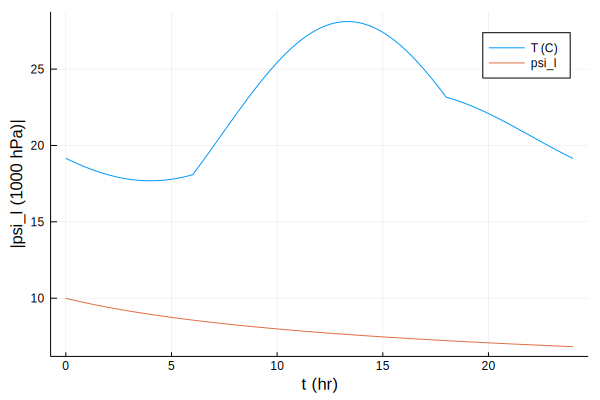

In [10]:
plot(t/3600, T_t-273.15*ones(size(T_t)),xlabel = "t (hr)",ylabel = "T (C)",label="T (C)",ylim=0:100)
plot!(t/3600,-psil_t/100000,xlabel = "t (hr)",ylabel = "|psi_l (1000 hPa)|",label="psi_l",ylim=0:100)

In [11]:
savefig(joinpath(output_dir, "T_psi_t.png"))

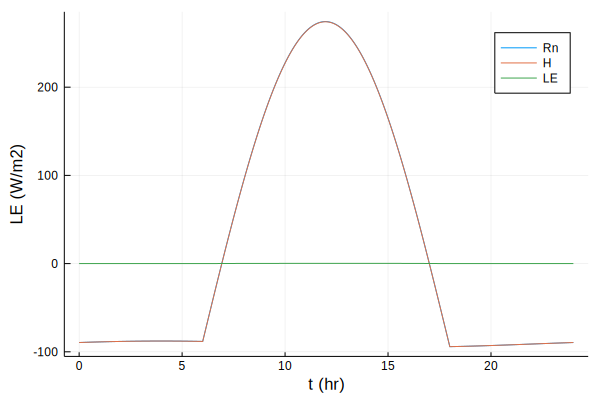

In [12]:
plot(t/3600,  Rn_t,xlabel = "t (hr)",ylabel = "Rn (W/m2)",label="Rn")
plot!(t/3600, H_t,xlabel  = "t (hr)",ylabel = "H (W/m2)" ,label="H")
plot!(t/3600, LE_t,xlabel = "t (hr)",ylabel = "LE (W/m2)",label="LE")